In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap03/'
OutputDir    = '3LassoCV-0904FFT/'
FileBaseName = '3LassoCV-0904FFT'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
from sklearn.model_selection import KFold
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoCV-0904FFT/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoCV-0904FFT/


計測データを模倣したデータ
$$
y(t)=\sum_{\nu=1}^{2}
\exp\left(-\frac{t}{\tau_\nu}\right)
\left(
  a_\nu
  \cos 2\pi{}f_\nu t
  +
  b_\nu
  \sin 2\pi{}f_\nu t
\right)
$$
$$
\begin{array}{|c|c|c|c|}
  \hline
  f_\nu\,\,({\rm THz})& \tau_\nu\,\, ({\rm ps}) & a_\nu\,\, ({\rm V})& b_\nu\,\, ({\rm V})\\
  \hline
  2.91 & 4.35 & -9.35\times10^{-7}  & -0.493\times10^{-7} \\
  2.07 & 1.96 & +0.218\times10^{-7} & +3.53\times10^{-7} \\
  \hline
\end{array}
$$
* 時間:$t=[0.0,8.0\times10^{-12}]$ sec $= [0.0,8.0]$ ps

In [4]:
############################################
M = 400
#
############################################
# time (ps) axis
tt = np.linspace( 0.0, +8.0, endpoint=False, num=M )
#
tt_sec = tt * 1.0E-12
#
dt = (np.amax(tt) - np.amin(tt))/(M-1.0)
print('dt   =', dt, ' ps' )
#
############################################
# frequency (THz) axis
df = 1.0 / (M*dt)
print('df   =', df, ' THz' )
#
fmax = 1.0 /(2.0 * dt)
print('fmax = ', fmax, ' THz' )
#
ff = np.linspace(0.0, fmax, endpoint=True, num=int(M/2+1) )
#
ff_Hz = ff * 1.0E12
#
ff_k = ff.size
#
############################################
# 計測データを模倣したデータ
##################
# モードパラメータ
# Mode 1
f_1   = 2.91      # THz
w_1   = 2.0 * np.pi * f_1
tau_1 = 4.35      # ps
a_1   = -9.35E-7  # V
b_1   = -0.493E-7 # V
#
# Mode 2
f_2   = 2.07      # THz
w_2   = 2.0 * np.pi * f_2
tau_2 = 1.96      # ps
a_2   = +0.218E-7 # V
b_2   = +3.53E-7  # V
#
##################
# 真値データ
y_true = np.exp( -tt/tau_1 ) * \
         (a_1 * np.cos( w_1 * tt ) + \
          b_1 * np.cos( w_1 * tt ) ) + \
         + np.exp( -tt/tau_2 ) * \
         (a_2 * np.cos( w_2 * tt ) + \
          b_2 * np.cos( w_2 * tt ) )
############################################
# デモデータなので、同じ結果になるように乱数のシードを設定
rd.seed(2165)# rd.seed(1528), rd.seed(1865)
############################################
# 重畳する正規ノイズの標準偏差
sigma_noise = 2.0E-7
y_noise = rd.randn(M).reshape(M,)
y_noise = y_noise - np.mean( y_noise )
y_noise = y_noise / np.std( y_noise )
#
y_wn = y_true + sigma_noise * y_noise

dt   = 0.02  ps
df   = 0.125  THz
fmax =  25.0  THz


時系列データを描くグラフ関数

In [5]:
############################################
def figaxis_TimeSeries( axis, tt, y_sets, title=None ):
  #
  # 時系列のx軸の設定
  xmin = np.amin( tt )
  xmax = np.amax( tt )
  #
  axis.set_xlim( xmin, xmax )
  axis.set_xlabel( r'time $t$ (ps)' )
  #
  # 時系列のy軸の設定
  axis.set_ylabel( 'Intensity' )
  #
  ymax = 0.0
  ymin = 0.0
  #
  # yデータセットの描画
  for y_set in y_sets:
    #
    # y_set [ y_data, label, color, width, style ]
    #
    # 全てのデータで yの最大値
    ymax_ = np.amax(y_set[0])
    if ymax_ > ymax:
      ymax = ymax_
    #
    # 全てのデータで yの最小値
    ymin_ = np.amin(y_set[0])
    if ymin_ < ymin:
      ymin = ymin_
    #
    # グラフの描画
    axis.plot( tt, y_set[0], label=y_set[1], color=y_set[2], linewidth=y_set[3], linestyle=y_set[4] )
  #
  # y軸の範囲設定
  y_center = (ymax + ymin)/2.0
  y_width  = (ymax - ymin)/2.0
  #
  axis.set_ylim( y_center - 1.2 * y_width, y_center + 1.2 * y_width )
  #
  # 凡例
  axis.legend(loc='upper right')
  #
  if title is not None:
    plt.title( title )
  #
  return

############################################
def Grf_TimeSeries( tt, y_sets, title=None ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,6))
  #
  fig.subplots_adjust(left=0.19, right=0.98, top=0.95, bottom=0.1,wspace=0.25 )
  #
  ####################
  # 時系列データのグラフ
  ax1 = fig.add_subplot(1,1,1)
  #
  figaxis_TimeSeries( ax1, tt, y_sets )
  #
  ####################
  # グラフの出力
  plt.show()
  #
  return fig

元データのグラフ

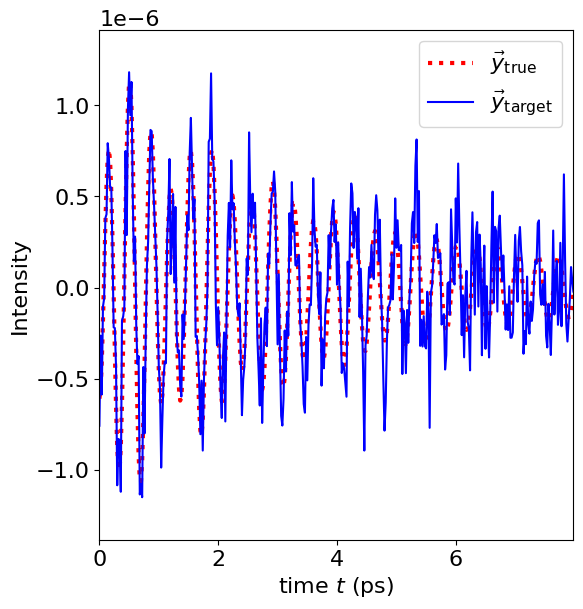

In [6]:
############################################
y_target = y_wn
############################################
y_true_set   = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
y_target_set = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
#
y_sets = [ y_true_set, y_target_set ]
#
fig = Grf_TimeSeries( tt, y_sets )
#
# fig.savefig( FilePath + FileBaseName + '-y-orig.pdf' )

データの標準化
* sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

データに対し、以下の前処理を行う
1. 平均値$\mu$を差し引き
2. 単位分散にスケーリング

して、特徴を標準化する。サンプル$x$の標準化は以下の式で計算される。
$$
 z = \frac{x - \mu}{s}
$$
* $\mu$: サンプルの平均値。但し with_mean=False の場合は 0
* $s$学習サンプルの標準偏差。但しwith_std=False の場合は 1

$\bullet$ 多次元配列 (n_samples, n_features) を想定しているため、(n_samples)] である1次元データに適用する場合は、reshapeしておく必要がある。

In [7]:
############################################
scaler = prep.StandardScaler()
#
print( y_target.shape )
print( y_target.reshape([-1,1]).shape )
#
scaler.fit( y_target.reshape([-1,1]) )
#
# ノイズが重畳したデータ
y_target_ss = scaler.transform( y_target.reshape([-1,1]) )
print( y_target_ss.shape )
#
y_target_scale = scaler.scale_[0]
y_target_mean  = scaler.mean_[0]
#
print( 'scaler.mean_  =', y_target_mean  )
print( 'scaler.scale_ =', y_target_scale )
#
y_target_ss = y_target_ss.reshape([-1,])
print( y_target_ss.shape )
print( np.mean( y_target_ss ) )
print( np.std( y_target_ss ) )
#
# 真値データ
y_true_ss = scaler.transform( y_true.reshape([-1,1]) )
y_true_ss = y_true_ss.reshape([-1,])
#
print( np.mean( y_true_ss ) )
print( np.std( y_true_ss ) )
#
# 標準化した真値データとデータとの標準偏差
y_ss_var = np.var(y_target_ss - y_true_ss)
print( 'var(y^SS-y^SS_true) = ', y_ss_var )

(400,)
(400, 1)
(400, 1)
scaler.mean_  = -1.7962225401806694e-09
scaler.scale_ = 4.101989096420784e-07
(400,)
-1.8873791418627663e-17
1.0
-6.661338147750939e-18
0.8998427259255835
var(y^SS-y^SS_true) =  0.23772288273764147


フーリエ変換

フーリエ変換は、周期が$T$の時系列データ
$$
x(t+T)=x(t),\,\,\,t\in[0,T)
$$
を満たす「任意」の周期関数$x(t)$を、
$$
\Delta{}f=\frac{1}{T}
$$
として、次式の様に展開する。
$$
x(t)
=
\sum_{n=1}^{\infty}
\left[
  a_n
  \cos\left(2\pi\;n\;\Delta{}f\;t\right)
  +
  b_n
  \sin\left(2\pi\;n\;\Delta{}f\;t\right)
\right]
$$
展開係数は次式で得られる。
$$
a_n
=
\frac{2}{T}
\int_{-T/2}^{+T/2}
x(\tau)
\cos\left(2\pi\;n\;\Delta{}f\;\tau\right)d\tau
$$

$$
b_n
=
\frac{2}{T}
\int_{-T/2}^{+T/2}
x(\tau)
\sin\left(2\pi\;n\;\Delta{}f\;\tau\right)d\tau
$$

ナイキスト・シャノンのサンプリング定理

実験データでは、時間系列を連続的に測定することは不可能で、一般的に等時間ステップで計測され、また、無限に計測することもかなわない。等時間ステップが$\Delta{}t$で、$M$個の時系列データがあるとする。フーリエ級数の$n$の和で$\infty$までの和を取ることはできないため、和の周波数の上限を設定する必要がある。

* ナイキスト周波数: $f_{\rm Nyquist}$

その周波数の上限は、以下で定義される。
$$
f_{\rm Nyquist}
:=
\frac{1}{2\Delta{}t}
$$
これは$2\Delta{}t$の周期よりも短い周波数は計測できないことを意味する。

* 周波数の分解能: $\Delta{}f$

一方フーリエ級数で展開した際の、周波数の分解能$\Delta{}f$は次式で定義される。
$$
\Delta{}f
:=
\frac{1}{M\Delta{}t}
$$

これは、計測されている時間領域が$M\Delta{}t$であることによる。フーリエ級数の前提として周期$T$で繰り返される任意関数が前提で、計測されている時間領域が最長の周期と考えるためである。つまり、$M\Delta{}t$の時間領域データが繰り返されていることが前提となっている。

numpyのDiscrete Fourier Transform (FFT)
* Reference: https://numpy.org/doc/stable/reference/routines.fft.html
* 実数データのfft: https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html#numpy.fft.rfft

In [8]:
############################################
# 標準化したデータをFFT
#
fft_true     = np.fft.rfft( y_true_ss )
fft_true_re  = np.real( fft_true )
fft_true_im  = np.imag( fft_true )
fft_true_mag = np.abs( fft_true )
# 規格化しておく
fft_true_mag = fft_true_mag / np.amax( fft_true_mag )
fft_true_ang = np.angle( fft_true ) / np.pi * 180.0
#
fft_target     = np.fft.rfft( y_target_ss )
fft_target_re  = np.real( fft_target )
fft_target_im  = np.imag( fft_target )
fft_target_mag = np.abs( fft_target )
# 規格化しておく
fft_target_mag = fft_target_mag / np.amax( fft_target_mag )
fft_target_ang = np.angle( fft_target ) / np.pi * 180.0

フーリエスペクトル等を描画する関数

In [9]:
############################################
def figaxis_FFTspectra( axis, freq, y_sets, freq_max=None, title=None ):
  #
  # 周波数のx軸の設定
  xmax = np.amax( freq )
  #
  if freq_max is not None:
    axis.set_xlim( 0, freq_max )
  else:
    axis.set_xlim( 0, xmax )
  #
  axis.set_xlabel( r'freq. $f$ (THz)' )
  #
  # y軸の設定
  axis.set_ylabel( 'Intensity (normalized)' )
  #
  ymax = 0.0
  #
  # markers
  markers = []
  #
  # yデータセットの描画
  for y_set in y_sets:
    #
    # y_set [ y_data, mode, label, color, width, style ]
    #   mode = 0: plot
    #   mode = 1: marker
    #   mode = 2: vlines
    #
    if   y_set[1]==0:
      # グラフの描画, mode = 0: plot
      axis.plot( freq, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1]==1:
      # marker
      markers.append( y_set )
      #
    elif y_set[1]==2:
      # vlines
      axis.vlines( freq, 0, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
  #
  # y軸の範囲設定
  ybot, ytop = axis.set_ylim( 0.0, 1.2 )
  #
  # markersの描画
  for marker in markers:
    #
    axis.vlines( marker[0], ybot, ytop, label=marker[2], color=marker[3], linewidth=marker[4], linestyle=marker[5] )
  #
  # 凡例
  axis.legend(loc='upper right')
  #
  if title is not None:
    plt.title( title )
  else:
    plt.title( 'FFT spectrum' )
  #
  #
  return

############################################
def Grf_FFTspectra( freq, y_sets, freq_max=None, title=None ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,6))
  #
  fig.subplots_adjust(left=0.19, right=0.98, top=0.92, bottom=0.1,wspace=0.25 )
  #
  ####################
  # FFTspectraデータのグラフ
  ax1 = fig.add_subplot(1,1,1)
  #
  figaxis_FFTspectra( ax1, freq, y_sets, freq_max=freq_max )
  #
  ####################
  # グラフの出力
  plt.show()
  #
  return fig

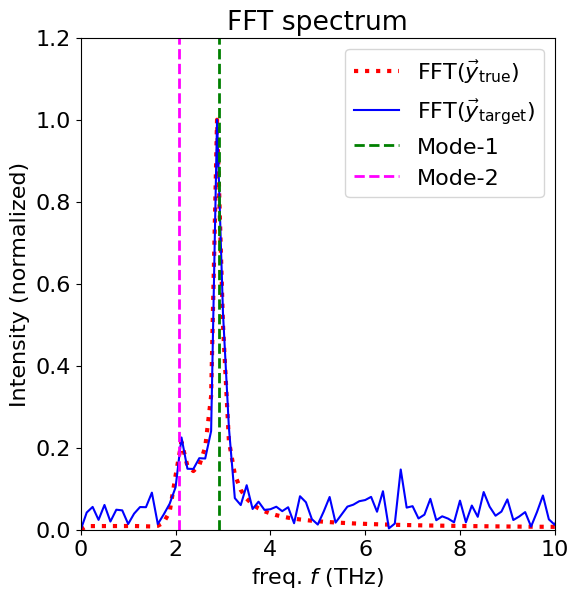

In [10]:
############################################
fft_true_set   = [ fft_true_mag,   0, r'FFT($\vec{y}_{\rm true}$)',   'red',       3, 'dotted' ]
fft_target_set = [ fft_target_mag, 0, r'FFT($\vec{y}_{\rm target}$)', 'blue',    1.5, 'solid'  ]
Mode1_mode     = [ f_1,            1, 'Mode-1',                       'green',   2.0, 'dashed' ]
Mode2_mode     = [ f_2,            1, 'Mode-2',                       'magenta', 2.0, 'dashed' ]
#
fft_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set ]
#
fig = Grf_FFTspectra( ff, fft_sets, freq_max=10 )
#
# fig.savefig( FilePath + FileBaseName + '-FFT.pdf' )

フーリエ変換を線形写像で表す
* $f_{n}=n\Delta{}f$ ($n=1,\cdots, N-1$)として
$$
\left(
  \begin{array}{c}
    y_{1}  \\[0.2em]
    y_{2}  \\[0.2em]
    \vdots \\[0.2em]
    \vdots \\[0.2em]
    y_{M}  
  \end{array}
\right)
=
\left(
  \begin{array}{cccccc}
    \color{red}{\sin(2\pi{}f_{1}t_{1})}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_1)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_1)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_1)}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_2)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_2)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_2)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_2)}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_M)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_M)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_M)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_M)}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \color{red}{a_{1}}  \\
    \color{red}{\vdots} \\
    \color{red}{a_{N-1}}  \\
    \color{lightblue}{b_{1}}  \\
    \color{lightblue}{\vdots} \\
    \color{lightblue}{b_{N-1}}  
  \end{array}
\right)
$$

計画行列
$$
\boldsymbol{X}
=
\left(
  \begin{array}{cccccc}
    \color{red}{\sin(2\pi{}f_{1}t_{1})}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_1)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_1)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_1)}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_2)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_2)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_2)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_2)}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_M)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_M)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_M)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_M)}
  \end{array}
\right)
$$

In [11]:
############################################
# 0 < ff < fmax の周波数成分で計画行列を用意する
#
ff2pi = 2.0 * np.pi * ff[ (ff > 0)&(ff < fmax) ]
print('ff2pi.size =', ff2pi.size )
print('ff2pi =', ff2pi )
#
############################################
# sin(df), sin(2df), ...
# cos(df), cos(2df), ...
#
w_K = ff2pi.size * 2
print('w_K        =', w_K )
#
X = np.zeros( (M, w_K ) )
#
for k in range( ff2pi.size ):
    omega = ff2pi[ k ] * tt
    # print( omega )
    kksin = k
    kkcos = k + ff2pi.size
    X[:, kksin ] = np.sin( omega )
    X[:, kkcos ] = np.cos( omega )
#
print('X.shape    =', X.shape )

ff2pi.size = 199
ff2pi = [  0.78539816   1.57079633   2.35619449   3.14159265   3.92699082
   4.71238898   5.49778714   6.28318531   7.06858347   7.85398163
   8.6393798    9.42477796  10.21017612  10.99557429  11.78097245
  12.56637061  13.35176878  14.13716694  14.9225651   15.70796327
  16.49336143  17.27875959  18.06415776  18.84955592  19.63495408
  20.42035225  21.20575041  21.99114858  22.77654674  23.5619449
  24.34734307  25.13274123  25.91813939  26.70353756  27.48893572
  28.27433388  29.05973205  29.84513021  30.63052837  31.41592654
  32.2013247   32.98672286  33.77212103  34.55751919  35.34291735
  36.12831552  36.91371368  37.69911184  38.48451001  39.26990817
  40.05530633  40.8407045   41.62610266  42.41150082  43.19689899
  43.98229715  44.76769531  45.55309348  46.33849164  47.1238898
  47.90928797  48.69468613  49.48008429  50.26548246  51.05088062
  51.83627878  52.62167695  53.40707511  54.19247327  54.97787144
  55.7632696   56.54866776  57.33406593  58.11946409 

計画行列のヒートマップを描く

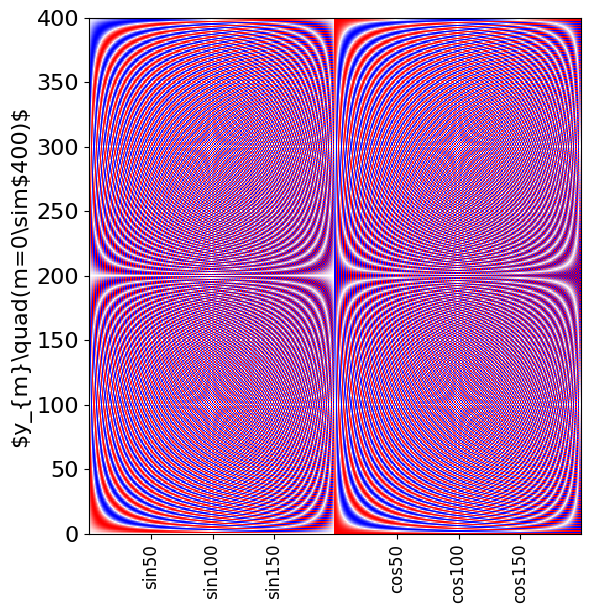

In [12]:
############################################
plt.rcParams["font.size"] = 16
#
fig = plt.figure(figsize=(6,6))
#
fig.subplots_adjust(left=0.15, right=0.97, top=0.98, bottom=0.12, wspace=0.25 )
#
####################
ax1 = fig.add_subplot(1,1,1)
#
heatmap = ax1.pcolor( X, cmap=plt.cm.bwr)
#
ax1.set_ylabel(r'$y_{m}\quad(m=0\sim$%d)$' % M )
#
ax1.set_xticks( [ 50, 100, 150, ff2pi.size+50, ff2pi.size+100, ff2pi.size+150 ] )
ax1.set_xticklabels( ['sin50', 'sin100', 'sin150', 'cos50', 'cos100', 'cos150'],
                     rotation=90, fontsize=12)
#
plt.show()
#
# fig.savefig( FilePath + FileBaseName + '-Xmat.pdf' )

フーリエスペクトルは、最大強度で規格化したものとする。

In [13]:
############################################
# 得られた解から強度データを計算
def make_ff_mag_( a0_, w_ ):
  #
  ff_mag_ = np.zeros_like( ff )
  #
  # 切片項
  ff_mag_[ 0 ] = a0_
  #
  idx = 1
  for k in range( ff2pi.size ):
    kksin = k
    kkcos = k + ff2pi.size
    mag_ = np.sqrt( w_[kksin]**2 + w_[kkcos]**2 )
    ff_mag_[ idx ] = mag_
    idx = idx + 1
  #
  # 規格化しておく
  if np.amax(ff_mag_) > 0:
    ff_mag_ = ff_mag_ / np.amax(ff_mag_)
  #
  return ff_mag_

---
$\textrm{CV}_{k}(\alpha)$ と $\textrm{CVE}(\alpha)$ を描画するグラフ関数

In [14]:
############################################
def SubGrf_CVk_CVE_SE( axis, dictCV_, interval_=5,
                       on_CV_CVs_k_ = True, on_CV_CVEs_=True, on_CV_SEs_=True,
                       on_CV_alpha_=True, on_CV_1SE_=True, title_=None, title_c=False ):
  #
  #############
  CV_fold_        = dictCV_[ 'CV_fold' ]
  alphas_         = dictCV_[ 'CV_alphas' ]
  CV_CVs_k_       = dictCV_[ 'CV_CVs_k' ]
  CV_CVEs_        = dictCV_[ 'CV_CVEs' ]
  CV_SEs_         = dictCV_[ 'CV_SEs' ]
  CV_alpha_       = dictCV_[ 'CV_alpha' ]
  CV_alpha_idx_   = dictCV_[ 'CV_alpha_idx' ]
  CV_alpha_CVE_   = CV_CVEs_[ CV_alpha_idx_ ]
  CV_alpha_SE_    = CV_SEs_[ CV_alpha_idx_ ]
  CV_coef_        = dictCV_[ 'CV_coef' ]
  CV_coef_L0_     = np.count_nonzero( CV_coef_ )
  CV_1SE_level_   = dictCV_[ 'CV_1SE_level' ]
  CV_1SE_alpha_   = dictCV_[ 'CV_1SE_alpha' ]
  CV_1SE_coef_    = dictCV_[ 'CV_1SE_coef' ]
  CV_1SE_coef_L0_ = np.count_nonzero( CV_1SE_coef_ )
  #
  #############
  axis.set_xscale('log')
  axis.set_xlabel( r'$\alpha$' )
  #
  #############
  ylabel = ''
  if on_CV_CVs_k_:
    ylabel = ylabel + r'${\rm CV}_{k}(\alpha)$ '
  #
  if on_CV_CVEs_:
    if on_CV_SEs_:
      ylabel = ylabel + r'${\rm CVE}(\alpha)\pm{\rm SE}(\alpha)$'
    else:
      ylabel = ylabel + r'${\rm CVE}(\alpha)$'
  #
  axis.set_ylabel(  ylabel, color='black' )
  #
  if on_CV_CVs_k_:
    for fold_ in range(CV_fold_):
      label_CV_CVs_k_ = r'${\rm CV}_{%d}(\alpha)$' % (fold_+1)
      axis.plot( alphas_, CV_CVs_k_[:, fold_], linestyle='dashed', label=label_CV_CVs_k_, linewidth=1.5 )
  #
  if on_CV_CVEs_:
    axis.plot( alphas_, CV_CVEs_, linestyle='solid', linewidth=1.5, color='red',label=r'${\rm CVE}(\alpha)$')
  #
  # CVEの1SE
  if on_CV_SEs_:
    axis.errorbar( CV_alpha_, CV_alpha_CVE_, yerr=CV_alpha_SE_, linestyle='solid', linewidth=4, color='red')
  #
  #############
  # interval 間隔
  if on_CV_SEs_:
    axis.errorbar( alphas_, CV_CVEs_, yerr=CV_SEs_, linestyle='solid', errorevery=interval_,
                   linewidth=1.5, color='red',label=r'CVE$\pm$1SE')
  #
  #############
  if on_CV_alpha_:
    CV_alpha_label_ = r'$\hat{\alpha}_{\rm CVE}$=%.3E (L0=%d)' % (CV_alpha_, CV_coef_L0_)
    # axis.axvline( CV_alpha_, color='black', linestyle='dashed', linewidth=1.5, label=CV_alpha_label_ )
    axis.axvline( CV_alpha_, color='black', linestyle='dashed', linewidth=1.5 )
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( CV_alpha_, axis_top - 0.05*(axis_top-axis_bot),
               CV_alpha_label_, fontsize=10, rotation=90,
               horizontalalignment='center', verticalalignment='top',
               color='white', backgroundcolor='black', zorder=2.0)
  #
  #############
  if on_CV_1SE_:
    CV_1SE_level_label_ = r'CVE($\hat{\alpha}_{\rm CVE}$)+1SE($\hat{\alpha}_{\rm CVE}$)'
    # axis.axhline( CV_1SE_level_, color='green', linestyle='dotted', linewidth=1.5, label=CV_1SE_level_label_ )
    axis.axhline( CV_1SE_level_, color='green', linestyle='dotted', linewidth=1.5 )
    #
    (axis_left, axis_right) = axis.set_xlim()
    #
    axis.text( axis_left, CV_1SE_level_,
               CV_1SE_level_label_, fontsize=10, rotation=00,
               horizontalalignment='left', verticalalignment='center',
               color='green', backgroundcolor='white', zorder=2.0)
    #
    CV_1SE_alpha_label_ = r'$\hat{\alpha}_{\rm 1SE}$=%.3E (L0=%d)' % (CV_1SE_alpha_, CV_1SE_coef_L0_)
    # axis.axvline( CV_1SE_alpha_, color='black', linestyle='dashed', linewidth=1.5, label=CV_1SE_alpha_label_ )
    axis.axvline( CV_1SE_alpha_, color='green', linestyle='dashed', linewidth=1.5)
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( CV_1SE_alpha_, axis_top - 0.05*(axis_top-axis_bot),
               CV_1SE_alpha_label_, fontsize=10, rotation=90,
               horizontalalignment='center', verticalalignment='top',
               color='white', backgroundcolor='green', zorder=2.0)
  #
  #############
  if title_ is None:
    title_ = 'LassoCV(), '
    if on_CV_CVs_k_:
      title_ = title_ + r'${\rm CV}_{k}(\alpha)$ '
    #
    if on_CV_CVEs_:
      if on_CV_SEs_:
        title_ = title_ + r'${\rm CVE}(\alpha)\pm{\rm SE}(\alpha)$'
      else:
        title_ = title_ + r'${\rm CVE}(\alpha)$'
  #
  if title_c:
    title_ = '(c) ' + title_
  #
  plt.title( title_ )
  #
  plt.legend( loc='upper left',  fontsize=12 )
  #
  return
  #
############################################
def Grf_CVk_CVE_SE( dictCV_, interval_=5,
                    on_CV_CVs_k_ = True, on_CV_CVEs_=True, on_CV_SEs_=True,
                    on_CV_alpha_=True, on_CV_1SE_=True, title_=None  ):
  #
  ########################
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,5))
  #
  fig.subplots_adjust(left=0.15, right=0.97, top=0.92, bottom=0.12, wspace=0.3)
  #
  ########################
  ########################
  # MSE, L0、RMSDを描画するグラフ
  ax1 = fig.add_subplot( 1, 1, 1 )
  #
  SubGrf_CVk_CVE_SE( ax1, dictCV_, interval_=interval_,
                    on_CV_CVs_k_ = on_CV_CVs_k_, on_CV_CVEs_=on_CV_CVEs_, on_CV_SEs_=on_CV_SEs_,
                    on_CV_alpha_=on_CV_alpha_, on_CV_1SE_=on_CV_1SE_, title_=title_ )
  #
  plt.show()
  #
  return fig

---
交差検証

(1) データの分割

まずデータセット $\boldsymbol{D}=\{\cdots,(x_m,y_m),\cdots\}$  $(m=1,\cdots,M)$ を $\color{LightBlue}{(M-M_{k})個}$ の$\color{LightBlue}{訓練データ\boldsymbol{D}_k^\textrm{tr}}$ と、$\color{Red}{M_{k}個}$ の $\color{Red}{検証データ\boldsymbol{D}_k^\textrm{te}}$ に分割（$\boldsymbol{D}=\{\color{LightBlue}{\boldsymbol{D}_k^\textrm{tr}}, \color{Red}{\boldsymbol{D}_k^\textrm{te}}\}$）する。

$$
    \boldsymbol{D}
    =
    \left\{
        \begin{array}{lll}
            \color{LightBlue}{
                \boldsymbol{D}_k^\textrm{tr}
                :=
                \left\{
                    \cdots, (x_m, y_m), \cdots
                \right\}
            }
            , &
            \color{LightBlue}{
                \boldsymbol{y}_k^\textrm{tr}
                :=
                \big\{
                    \underbrace{
                        \cdots, y_m, \cdots
                    }_{(M-M_{k})個}
                \big\}
            }
            , &
            \color{LightBlue}{
                m \notin
            }
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
            }
            \\
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
                :=
                \left\{
                    \cdots, (x_m, y_m), \cdots
                \right\}
            }
            , &
            \color{Red}{
                \boldsymbol{y}_k^\textrm{te}
                :=
                \big\{
                    \overbrace{
                        \cdots, y_m, \cdots
                    }^{M_{k}個}
                \big\}
            }
            , &
            \color{Red}{
                m \in
            }
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
            }
        \end{array}
    \right.    
$$

このデータ分割は、以下の規則に従って行う。

* 全データ点からランダムな位置（シャッフル）で検証データを抜粋して分割する。

* $K$-fold交差検証では、$K~(k=1,\cdots,K)$ 組の $\color{LightBlue}{\boldsymbol{D}_k^\textrm{tr}}$,  $\color{Red}{\boldsymbol{D}_k^\textrm{te}}$ を用意する。

* 全データ点（$m=1,\cdots,M$）を $k=1,\cdots,K$ で、一度だけ、かつ、必ず $\color{Red}{検証データ\boldsymbol{D}_k^\textrm{te}}$ として選択する。

(2) 訓練データによる学習

$\color{LightBlue}{訓練データ\boldsymbol{D}_k^\textrm{tr}}$ を学習して、ある $\alpha$ におけるスパース解 $\color{LightBlue}{\hat{\boldsymbol{\omega}}_k^\textrm{tr}(\alpha)}$ をLASSO法を用いて得る。

$$
    \color{LightBlue}{
    \hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)
    =
    \textrm{argmin}_{\boldsymbol{\omega}_{k}^\textrm{tr}}
    \left[
        \frac{1}{2(M-M_{k})}
        \left\|
            \boldsymbol{y}_{k}^\textrm{tr}
            -
            \mathbf{X}_{k}^\textrm{tr}
            \,
            \boldsymbol{\omega}_{k}^\textrm{tr}
        \right\|_{2}^{2}
        +
        \alpha
        \left\|
            \boldsymbol{\omega}_{k}^\textrm{tr}
        \right\|_{1}
    \right]    
    },
$$

ここで $\color{LightBlue}{\mathbf{X}_{k}^\textrm{tr}}$ は、$\color{LightBlue}{訓練データ \boldsymbol{y}_{k}^\textrm{tr}}$ に対応する（検証データ分を抜いた）計画行列である。

(3) 検証データによる予測誤差の評価

得た $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ を用いて、 $\color{Red}{検証データ \boldsymbol{D}_k^\textrm{te}}$ を予測できるかを、予測の検定誤差 $\textrm{CV}_{k}(\alpha)$ を次式で評価する。

$$
    \textrm{CV}_{k}(\alpha)
    =
    \frac{1}{2M_{k}}
    \left\|
        \color{Red}{\boldsymbol{y}_{k}^\textrm{te}}
        -
        \color{Red}{\mathbf{X}_{k}^\textrm{te}}
        \color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}
    \right\|_2^2
$$

$\textrm{CV}_{k}(\alpha)$ は $\alpha$ に応じて以下のように振る舞う。

* $\alpha$が大き過ぎる場合（よりスパースな解）
    
  $\color{LightBlue}{訓練データ}$の学習で得られる $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ には、非ゼロ要素数が少なく勉強不足で、データを説明する主要素が不足している。そのため、$\color{Red}{検証データ}$を予測できず $\textrm{CV}_{k}(\alpha)$ は大きい。

* $\alpha$を小さくすると

  勉強不足が解消され、$\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ が $\color{Red}{検証データ}$ を予測できるようになり、$\textrm{CV}_{k}(\alpha)$ は改善（減少）する。

* $\alpha$が小さすぎる場合（過学習）

  $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ が $\color{LightBlue}{訓練データ}$ に含まれるランダムノイズまでも過学習してしまう。しかし $\color{LightBlue}{訓練データ}$ と $\color{Red}{検証データ}$ にそれぞれ重畳するノイズは無相関で、予測誤差が劣化する。

$\color{LightBlue}{訓練データ}$ と $\color{Red}{検証データ}$ を1組として、各 $k\;(=1,\cdots,K)$ 組において、$\textrm{CV}_{k}(\alpha)$ を評価する。


(4) 交差検証誤差

しかしデータの分割はランダムに行うため、各 $k\;(=1,\cdots,K)$ 組で $\textrm{CV}_{k}(\alpha)$ はばらついてしまうし、解析をやり直しても、分割に用いられる乱数が異なるため、それでもばらつく。そのため、$K$~$(k=1,\cdots,K)$組で次式の様に平均した交差検証誤差(CVE)を評価する。

$$
    \textrm{CVE}(\alpha)
    =
    \frac{1}{K}
    \sum_{k=1}^{K}
    \textrm{CV}_{k}(\alpha)
$$

予測誤差を最小化する意図の場合、次式の様に、交差検証誤差を最小化する $\hat{\alpha}_\textrm{CVE}$ を推定（モデル選択）する。

$$
    \hat{\alpha}_\textrm{\tiny{}CVE}
    =
    \textrm{argmin}_{\alpha}
    \textrm{CVE}(\alpha)
$$


(5) 交差検証誤差の標準誤差

各 $k\;(=1,\cdots,K)$組での$\textrm{CV}_{k}(\alpha)$ のばらつきを表す、$\textrm{CV}_{1}(\alpha),\cdots,\textrm{CV}_{K}(\alpha)$ の標本分散 $\sigma_\textrm{CV}^{2}(\alpha)$ は、次式で定義され、

$$
    \sigma_\textrm{CV}^{2}(\alpha)
    =
    \frac{1}{K-1}
    \sum_{k=1}^{K}
    \left[
        \textrm{CV}_{k}(\alpha)
        -
        \textrm{CVE}(\alpha)
    \right]^{2}
$$

平均である $\textrm{CVE}(\alpha)$ の標準誤差 $\textrm{SE}(\alpha)$ は、次式で定義される。

$$
    \textrm{SE}(\alpha)
    =
    \frac{
        \sigma_\textrm{CV}(\alpha)    
    }{\sqrt{K}}
$$

(6) 1SE則

(4)による $\alpha$ の推定は、予測誤差を最小化する意図で用いられるが、その推定された交差検証誤差 $\textrm{CVE}(\hat{\alpha}_\textrm{CVE})$ も $\textrm{SE}(\hat{\alpha}_\textrm{\tiny{}CVE})$ の誤差がある。ならばその誤差程度を許容して、より大きな $\alpha$を選択して、次式に基づき、スパースつまり簡素にデータを説明するモデルを選択する発見的方法（数学的根拠はない）がある。これは1SE則(One srandard error rule)と呼ばれる。

$$
    \hat{\alpha}_\textrm{1SE}
    =
    \textrm{argmax}_{\alpha}
    \textrm{CVE}(\alpha)
    ,
$$
$$    \textrm{subject to }
    \textrm{CVE}(\alpha)
    \leq
    \textrm{CVE}(\hat{\alpha}_\textrm{CVE})
    +
    \textrm{SE}(\hat{\alpha}_\textrm{CVE})
$$

---
シャッフルさせるために
* sklearn.model_selection.KFold
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

1. 引数
    * n_splitsint (5): 分割数
    * shuffle (False) : シャッフルするか否か

---
LassoCV
* sklearn.linear_model.LassoCV
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

1. 引数
    * cv (5): データ分解の方法

    シャッフルするために、KFold関数を次のように、shuffle=Trueを指定して用いる。
    ```
    cv = KFold(n_splits=fold, shuffle=True)
    ```
    * fit_intercept (True): 切片を計算するか否か

2. 返値
    * alpha_: CVEが最小化される$\hat{\alpha}$
    * coef_: その時の$\hat{\boldsymbol{\omega}}(\hat{\alpha})$
    * alphas_: 探索した$\alpha$のテーブル
    * mse_path_: $\alpha$のテーブルの各CVセットの平均誤差

In [15]:
############################################
dictCV = {}
############################################
CV_fold = 5
dictCV[ 'CV_fold' ] = CV_fold
#
############################################
# CV
CV = lm.LassoCV( cv=KFold( n_splits=CV_fold, shuffle=True ), max_iter=100000)
CV.fit(X, y_target_ss)
#
CV_alphas_ = CV.alphas_
dictCV[ 'CV_alphas' ] = CV_alphas_
print( 'CV_alphas_ = \n', CV_alphas_ )
#
CV_alpha_  = CV.alpha_
print( 'CV_alpha_           = ', CV_alpha_ )
dictCV[ 'CV_alpha' ] = CV_alpha_
#
CV_alpha_idx_ = np.where( CV_alphas_ == CV_alpha_ )[0][0]
print( 'CV_alpha_idx_       = ', CV_alpha_idx_ )
dictCV[ 'CV_alpha_idx' ] = CV_alpha_idx_
#
##############
# 回帰係数
CV_coef_   = CV.coef_
print( 'L0(CV_coef_)        = ', np.count_nonzero( CV_coef_ ) )
print( 'CV_coef_            = \n', CV_coef_ )
dictCV[ 'CV_coef' ] = CV_coef_
#
CV_intercept_ = CV.intercept_
print( 'CV_intercept_       = \n', CV_intercept_ )
dictCV[ 'CV_intercept' ] = CV_intercept_
#
##############
# fft
CV_fft_      = make_ff_mag_( CV_intercept_, CV_coef_ )
dictCV[ 'CV_fft' ] = CV_fft_
#
##############
# yの回帰
CV_yreg_      = X @ CV_coef_ + CV_intercept_
dictCV[ 'CV_yreg' ] = CV_yreg_
CV_yreg_RMSD_ = np.std( CV_yreg_ - y_target_ss )
print( 'CV_yreg_RMSD_       = ', CV_yreg_RMSD_ )
dictCV[ 'CV_yreg_RMSD' ] = CV_yreg_RMSD_
#
##############
# yの回帰 org
# y_target_scale = scaler.scale_[0]
# y_target_mean  = scaler.mean_[0]
CV_yreg_org_      = CV_yreg_ * y_target_scale + y_target_mean
dictCV[ 'CV_yreg_org' ] = CV_yreg_org_
CV_yreg_org_RMSD_ = np.std( CV_yreg_org_ - y_target )
print( 'CV_yreg_org_RMSD_       = ', CV_yreg_org_RMSD_ )
dictCV[ 'CV_yreg_org_RMSD' ] = CV_yreg_org_RMSD_
#
############
# CV_{k}(\alpha)
CV_CVs_k_     = CV.mse_path_
dictCV[ 'CV_CVs_k' ] = CV_CVs_k_
#
############
# CV_CVs_k_ の平均としてCVEを求める
CV_CVEs_      = np.mean( CV_CVs_k_, axis=1 )
print( 'CV_CVEs_            = \n', CV_CVEs_ )
dictCV[ 'CV_CVEs' ] = CV_CVEs_
#
# print( 'argmin(CV_CVEs_)    = ', np.argmin( CV_CVEs_ ) )
CV_minCVE_    = np.amin(CV_CVEs_)
dictCV[ 'CV_minCVE' ] = CV_minCVE_
# print( 'min(CV_CVEs_)       = \n', np.amin(CV_CVEs_ ) )
# print( 'CV_CVEs_[]          = \n', CV_CVEs_[CV_alpha_idx_] )
#
############
# CVEの標準誤差
CV_temp_  = np.zeros_like( CV_CVs_k_ )
#
for k in range( CV_fold ):
  CV_temp_[:, k] = (CV_CVs_k_[:, k] - CV_CVEs_)**2
#
CV_SEs_ = np.sqrt( np.sum( CV_temp_, axis=1 ) / ( ( CV_fold - 1 ) * CV_fold ) )
dictCV[ 'CV_SEs' ] = CV_SEs_
# print( 'CV_SEs_             = \n', CV_SEs_ )
#
############
# 1SE level
CV_1SE_level_ = CV_minCVE_ + CV_SEs_[CV_alpha_idx_]
print( 'CV_1SE_level_       = ', CV_1SE_level_ )
dictCV[ 'CV_1SE_level' ] = CV_1SE_level_
#
############
# 1SE level の alpha
# LassoCV()の alphas_ は、alphaが降順に並んでいる
for idx_ in np.arange(CV_alpha_idx_):# np.arange(CV_alpha_idx_, (len(CV_alphas_)-1) ):
  alpha_1   = CV_alphas_[idx_]
  alpha_2   = CV_alphas_[idx_+1]
  CV_CVEs_1 = CV_CVEs_[idx_]
  CV_CVEs_2 = CV_CVEs_[idx_+1]
  #
  if ((CV_CVEs_1 - CV_1SE_level_)*(CV_CVEs_2 - CV_1SE_level_)) <=0 :
    break
#
print( 'CV_1SE_level_ = %.6E' % CV_1SE_level_ )
print( '  1 = %.6f, %.6E' % (alpha_1, CV_CVEs_1) )
print( '  2 = %.6f, %.6E' % (alpha_2, CV_CVEs_2) )
#
ln_alpha_1 = np.log(alpha_1)
ln_alpha_2 = np.log(alpha_2)
#
ln_alpha = ln_alpha_1 + (CV_1SE_level_ - CV_CVEs_1) / (CV_CVEs_2 - CV_CVEs_1) * (ln_alpha_2 - ln_alpha_1)
#
CV_1SE_alpha_ = np.exp( ln_alpha )
print( 'CV_1SE_alpha_ = %.6f' % CV_1SE_alpha_ )
dictCV[ 'CV_1SE_alpha' ] = CV_1SE_alpha_
#
############
# 1SE level の alpha での回帰
lasso = lm.Lasso( alpha=CV_1SE_alpha_, max_iter=100000)
lasso.fit(X, y_target_ss)
#
CV_1SE_coef_ = lasso.coef_
print( 'L0(CV_1SE_coef_)        = ', np.count_nonzero( CV_1SE_coef_ ) )
print( 'CV_1SE_coef_            = \n', CV_1SE_coef_ )
dictCV[ 'CV_1SE_coef' ] = CV_1SE_coef_
#
CV_1SE_intercept_ = lasso.intercept_
print( 'CV_1SE_intercept_       = \n', CV_1SE_intercept_ )
dictCV[ 'CV_1SE_intercept' ] = CV_1SE_intercept_
#
##############
# 1SE level fft
CV_1SE_fft_      = make_ff_mag_( CV_1SE_intercept_, CV_1SE_coef_ )
dictCV[ 'CV_1SE_fft' ] = CV_1SE_fft_
#
##############
# 1SE level の alpha でのyの回帰
CV_1SE_yreg_      = X @ CV_1SE_coef_ + CV_1SE_intercept_
dictCV[ 'CV_1SE_yreg' ] = CV_1SE_yreg_
CV_1SE_yreg_RMSD_ = np.std( CV_1SE_yreg_ - y_target )
dictCV[ 'CV_1SE_yreg_RMSD' ] = CV_1SE_yreg_RMSD_
print( 'CV_1SE_yreg_RMSD       = ', CV_1SE_yreg_RMSD_ )
#
##############
# 1SE level の alpha でのyの回帰 org
# y_target_scale = scaler.scale_[0]
# y_target_mean  = scaler.mean_[0]
CV_1SE_yreg_org_      = CV_1SE_yreg_ * y_target_scale + y_target_mean
dictCV[ 'CV_1SE_yreg_org' ] = CV_1SE_yreg_org_
CV_1SE_yreg_org_RMSD_ = np.std( CV_1SE_yreg_org_ - y_target )
print( 'CV_1SE_yreg_org_RMSD_       = ', CV_1SE_yreg_org_RMSD_ )
dictCV[ 'CV_1SE_yreg_org_RMSD' ] = CV_1SE_yreg_org_RMSD_
#

CV_alphas_ = 
 [0.38649309 0.36044475 0.33615198 0.31349646 0.29236785 0.27266323
 0.25428664 0.23714858 0.22116556 0.20625974 0.19235852 0.1793942
 0.16730363 0.15602793 0.14551217 0.13570513 0.12655906 0.1180294
 0.11007462 0.10265596 0.09573729 0.08928492 0.08326741 0.07765547
 0.07242175 0.06754076 0.06298874 0.05874351 0.0547844  0.05109211
 0.04764867 0.04443731 0.04144239 0.03864931 0.03604447 0.0336152
 0.03134965 0.02923678 0.02726632 0.02542866 0.02371486 0.02211656
 0.02062597 0.01923585 0.01793942 0.01673036 0.01560279 0.01455122
 0.01357051 0.01265591 0.01180294 0.01100746 0.0102656  0.00957373
 0.00892849 0.00832674 0.00776555 0.00724217 0.00675408 0.00629887
 0.00587435 0.00547844 0.00510921 0.00476487 0.00444373 0.00414424
 0.00386493 0.00360445 0.00336152 0.00313496 0.00292368 0.00272663
 0.00254287 0.00237149 0.00221166 0.0020626  0.00192359 0.00179394
 0.00167304 0.00156028 0.00145512 0.00135705 0.00126559 0.00118029
 0.00110075 0.00102656 0.00095737 0.00089285 0.000

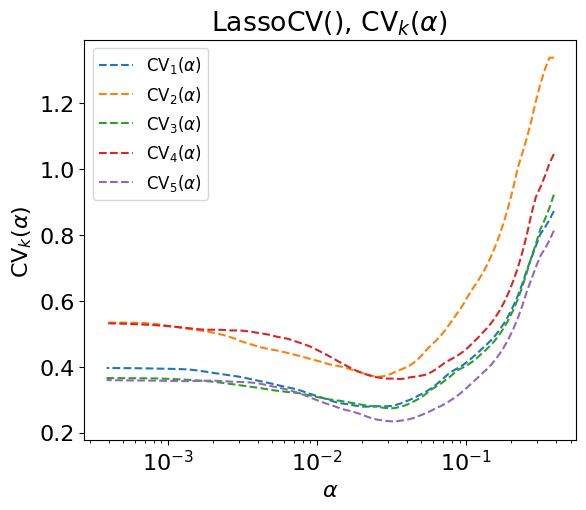

In [16]:
############################################
# CV_k(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV, on_CV_CVEs_=False, on_CV_SEs_=False, on_CV_alpha_=False, on_CV_1SE_=False )
#
pdfFName = FilePath + FileBaseName + '-CV_k-01.pdf'
fig.savefig( pdfFName )

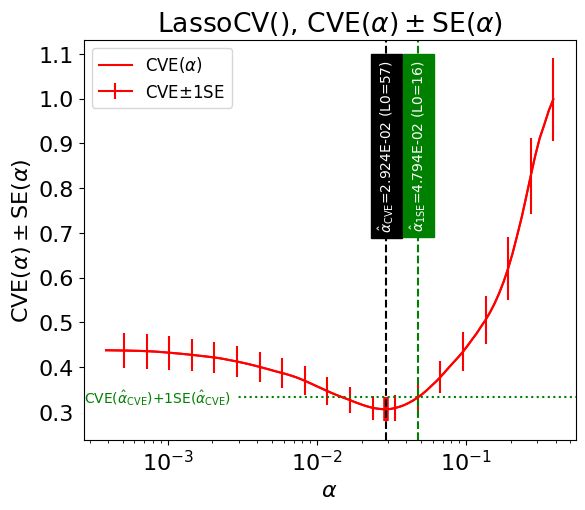

In [17]:
############################################
# CVE(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV, on_CV_CVs_k_=False )
#
pdfFName = FilePath + FileBaseName + '-CVE-01.pdf'
fig.savefig( pdfFName )

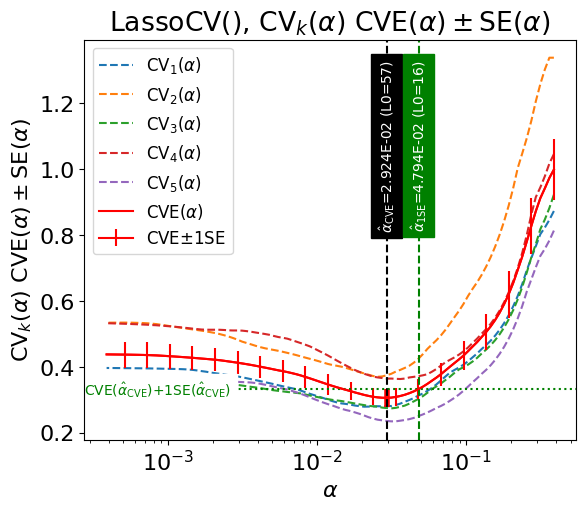

In [18]:
############################################
# CV_k(\alpha), CVE(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV )
#
pdfFName = FilePath + FileBaseName + '-CV_k-CVE-01.pdf'
fig.savefig( pdfFName )

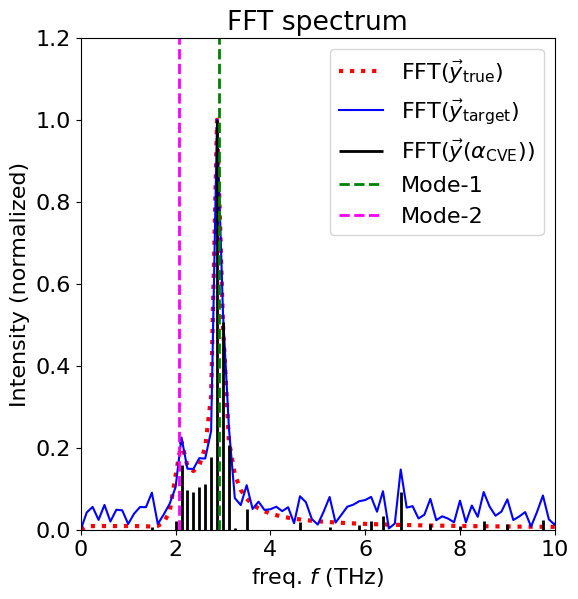

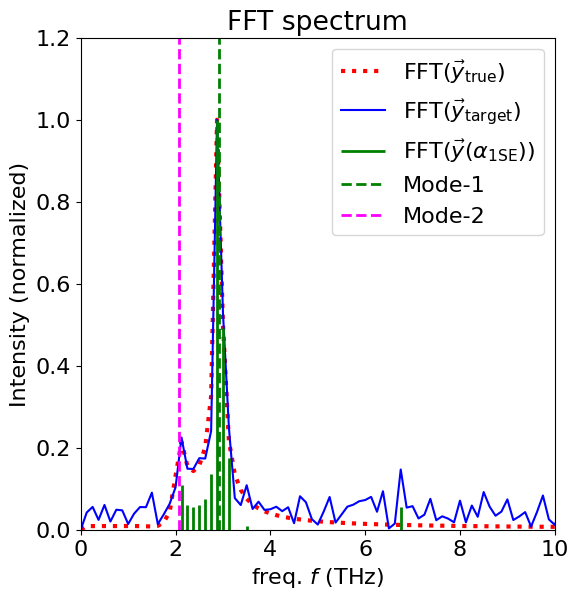

In [19]:
############################################
fft_true_set   = [ fft_true_mag,         0, r'FFT($\vec{y}_{\rm true}$)',       'red',       3, 'dotted' ]
fft_target_set = [ fft_target_mag,       0, r'FFT($\vec{y}_{\rm target}$)',     'blue',    1.5, 'solid'  ]
Mode1_mode     = [ f_1,                  1, 'Mode-1',                           'green',   2.0, 'dashed' ]
Mode2_mode     = [ f_2,                  1, 'Mode-2',                           'magenta', 2.0, 'dashed' ]
fft_CVE        = [ dictCV['CV_fft'],     2,r'FFT($\vec{y}(\alpha_{\rm CVE})$)', 'black',   2.0, 'solid'  ]
fft_1SE        = [ dictCV['CV_1SE_fft'], 2,r'FFT($\vec{y}(\alpha_{\rm 1SE})$)', 'green',   2.0, 'solid'  ]
#
fft_CVE_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set, fft_CVE ]
fig = Grf_FFTspectra( ff, fft_CVE_sets, freq_max=10 )
#
fft_1SE_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set, fft_1SE ]
fig = Grf_FFTspectra( ff, fft_1SE_sets, freq_max=10 )

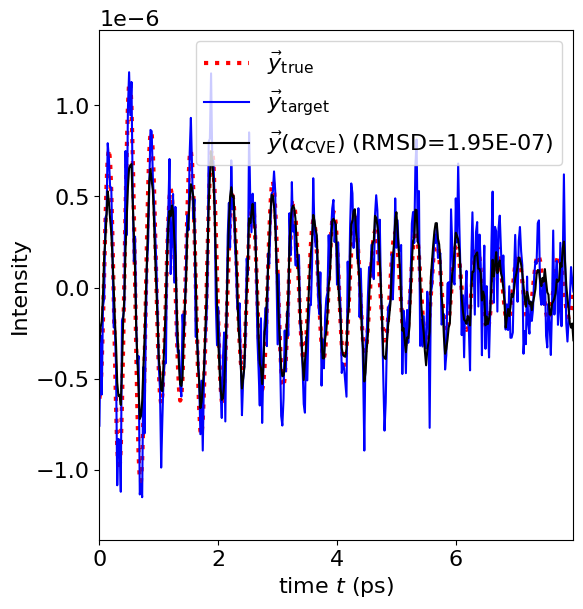

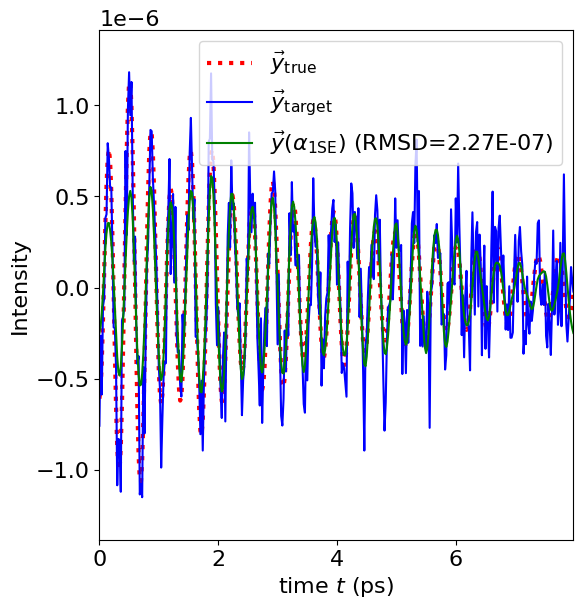

In [20]:
############################################
y_true_set    = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
y_target_set  = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
#
y_CVE_label   = r'$\vec{y}(\alpha_{\rm CVE})$ (RMSD=%.2E)' % dictCV[ 'CV_yreg_org_RMSD' ]
y_reg_CVE_set = [ dictCV[ 'CV_yreg_org' ], y_CVE_label, 'black', 1.5, 'solid'  ]
#
y_1SE_label   = r'$\vec{y}(\alpha_{\rm 1SE})$ (RMSD=%.2E)' % dictCV[ 'CV_1SE_yreg_org_RMSD' ]
y_reg_1SE_set = [ dictCV[ 'CV_1SE_yreg_org' ], y_1SE_label, 'green', 1.5, 'solid'  ]
#
y_CVE_sets = [ y_true_set, y_target_set, y_reg_CVE_set ]
fig = Grf_TimeSeries( tt, y_CVE_sets )
#
#
y_1SE_sets = [ y_true_set, y_target_set, y_reg_1SE_set ]
fig = Grf_TimeSeries( tt, y_1SE_sets )


---
まとめのグラフを描く関数

In [21]:
dictCV.keys()

dict_keys(['CV_fold', 'CV_alphas', 'CV_alpha', 'CV_alpha_idx', 'CV_coef', 'CV_intercept', 'CV_fft', 'CV_yreg', 'CV_yreg_RMSD', 'CV_yreg_org', 'CV_yreg_org_RMSD', 'CV_CVs_k', 'CV_CVEs', 'CV_minCVE', 'CV_SEs', 'CV_1SE_level', 'CV_1SE_alpha', 'CV_1SE_coef', 'CV_1SE_intercept', 'CV_1SE_fft', 'CV_1SE_yreg', 'CV_1SE_yreg_RMSD', 'CV_1SE_yreg_org', 'CV_1SE_yreg_org_RMSD'])

In [22]:
############################################
def Grf_summary( dictCV_, bool1SE=False ):
  #
  ##########################################
  CV_fold_      = dictCV_[ 'CV_fold' ]
  CV_alphas_    = dictCV_[ 'CV_alphas' ]
  CV_alpha_     = dictCV_[ 'CV_alpha' ]
  CV_alpha_idx_ = dictCV_[ 'CV_alpha_idx' ]
  CV_1SE_alpha_ = dictCV_[ 'CV_1SE_alpha' ]
  CV_CVs_k_     = dictCV_[ 'CV_CVs_k'     ]
  CV_CVEs_      = dictCV_[ 'CV_CVEs'      ]
  CV_minCVE_    = dictCV_[ 'CV_minCVE'    ]
  CV_SEs_       = dictCV_[ 'CV_SEs'       ]
  CV_1SE_level_ = dictCV_[ 'CV_1SE_level' ]
  #
  if bool1SE:
    # 1SE result
    coef_      = dictCV_[ 'CV_1SE_coef'          ]
    intercept_ = dictCV_[ 'CV_1SE_intercept'     ]
    fft_       = dictCV_[ 'CV_1SE_fft'           ]
    yreg_      = dictCV_[ 'CV_1SE_yreg_org'      ]
    yreg_RMSD_ = dictCV_[ 'CV_1SE_yreg_org_RMSD' ]
    #
    yreg_label = r'$\vec{y}(\alpha_{\rm 1SE})$ (RMSD=%.2E)' % yreg_RMSD_
    yreg_set   = [ yreg_, yreg_label,   'green',   2, 'solid' ]
    title1 = r'(a) LassoCV(), 1SE: $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha_{\rm 1SE})$'
    #
    fft_set   = [ fft_, 2,r'FFT($\vec{y}(\alpha_{\rm 1SE})$)', 'green',   2.0, 'solid'  ]
    title2 = r'(b) LassoCV(), 1SE: FFT $\vec{y}_{\rm true}, \vec{y}, \vec{y}(\alpha_{\rm 1SE})$'
    #
  else:
    # CVE result
    coef_      = dictCV_[ 'CV_coef'      ]
    intercept_ = dictCV_[ 'CV_intercept' ]
    fft_       = dictCV_[ 'CV_fft'     ]
    yreg_      = dictCV_[ 'CV_yreg_org'      ]
    yreg_RMSD_ = dictCV_[ 'CV_yreg_org_RMSD' ]
    #
    yreg_label = r'$\vec{y}(\alpha_{\rm CVE})$ (RMSD=%.2E)' % yreg_RMSD_
    yreg_set   = [ yreg_, yreg_label,   'black',   2, 'solid' ]
    title1 = r'(a) LassoCV(), CVE: $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha_{\rm CVE})$'
    #
    fft_set   = [ fft_, 2,r'FFT($\vec{y}(\alpha_{\rm CVE})$)', 'black',   2.0, 'solid'  ]
    title2 = r'(b) LassoCV(), CVE: FFT $\vec{y}_{\rm true}, \vec{y}, \vec{y}(\alpha_{\rm CVE})$'
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.99, top=0.86, bottom=0.12, wspace=0.20)
  #
  ##########################################
  y_true_set    = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
  y_target_set  = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
  #
  y_sets    = [ y_true_set, y_target_set, yreg_set ]
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  figaxis_TimeSeries( ax_y, tt, y_sets, title=title1 )
  #
  ##########################################
  fft_true_set   = [ fft_true_mag,         0, r'FFT($\vec{y}_{\rm true}$)',       'red',       3, 'dotted' ]
  fft_target_set = [ fft_target_mag,       0, r'FFT($\vec{y}_{\rm target}$)',     'blue',    1.5, 'solid'  ]
  Mode1_mode     = [ f_1,                  1, 'Mode-1',                           'green',   2.0, 'dashed' ]
  Mode2_mode     = [ f_2,                  1, 'Mode-2',                           'magenta', 2.0, 'dashed' ]
  #
  fft_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set, fft_set ]
  ###########
  ax_fft = fig.add_subplot(1, 3, 2)
  figaxis_FFTspectra( ax_fft, ff, fft_sets, freq_max=10, title=title2 )
  #
  ##########################################
  ax_CVk = fig.add_subplot(1, 3, 3)
  SubGrf_CVk_CVE_SE( ax_CVk, dictCV_, title_c=True )
  #
  plt.show()
  #
  return fig

---
交差検証のまとめのグラフ

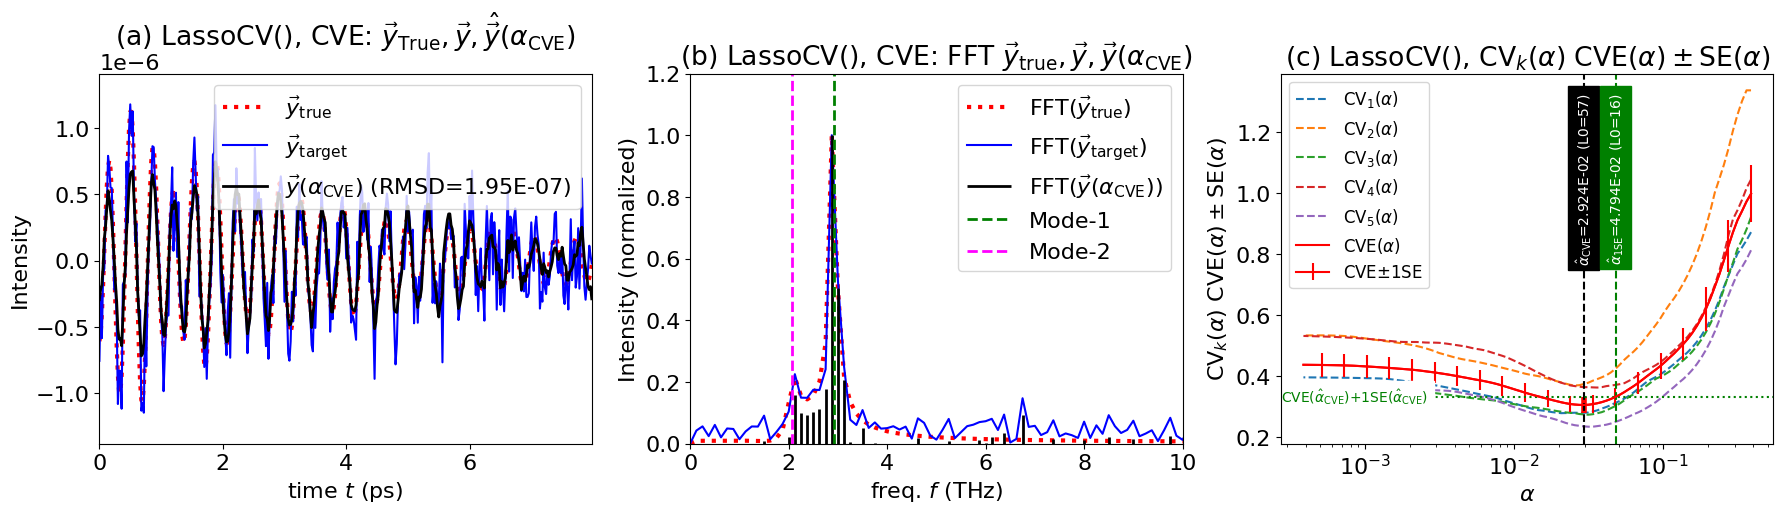

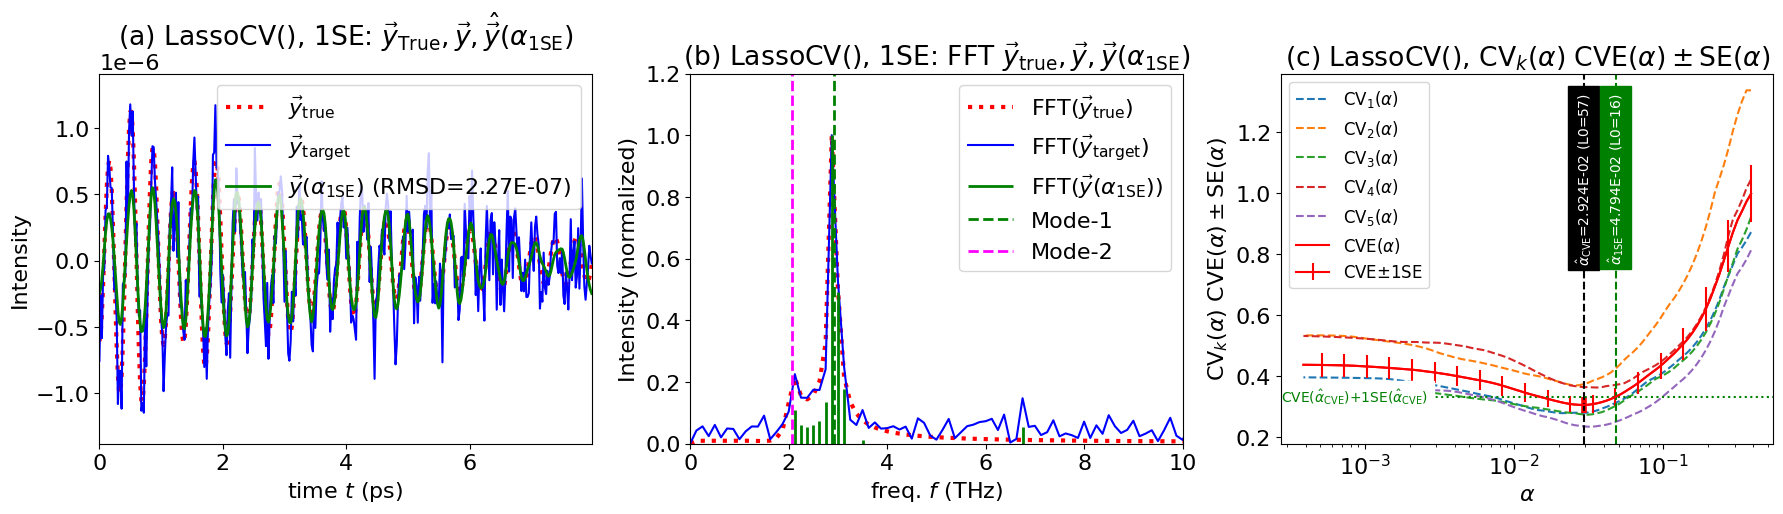

In [23]:
############################################
fig = Grf_summary( dictCV, bool1SE=False )
#
pdfFName = FilePath + FileBaseName + '-summary-CVE-01.pdf'
fig.savefig( pdfFName )
#
############################################
fig = Grf_summary( dictCV, bool1SE=True )
#
pdfFName = FilePath + FileBaseName + '-summary-1SE-01.pdf'
fig.savefig( pdfFName )